# Домашняя работа 5. Линейная регрессия. (33 балла)

> Линейная регрессия - это не повод для затяжной депрессии.

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.
4. Пришлите на почту ml-teachers ссылку на этот файл в вашем репозитории.
5. В теме письма указать `ML Homework #5: Name Surname`. Если тема будет неправильная, то задание не будет проверено.

**Дедлайн**: 27.11.2017 01:00 OMSK

    После дедлайна можно сдать, но вы получите штраф по баллам в рейтинге.

**Рассылка решений**: 30.11.2017 17:00 OMSK

    После рассылки задания совсем не имеют веса.

### Полезная литература

- [Первый конспект лекции про линейную регрессию из курса ФШЭ](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture02-linregr.pdf)
- [Второй конспект лекции про линейную регрессию из курса ФШЭ](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture03-linregr.pdf)
- [Теория из курса ODS](https://github.com/Yorko/mlcourse_open/blob/master/jupyter_notebooks/topic04_linear_models/topic4_linear_models_part1_mse_likelihood_bias_variance.ipynb)
- [Материалы из курса от МФТИ](https://www.coursera.org/specializations/machine-learning-data-analysis)
- [Статья про лин.рег. от ODS на habrahabr](https://habrahabr.ru/company/ods/blog/323890/)

## Данные

Возьмем датасет о стоимости домов: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data. Там же читайте описание данных.

Целевой переменной будет `SalePrice`. То есть мы будем предсказывать стоимость жилья на основе его характеристик. Это задание будет не то чтобы про линейную регрессию, но про попытку построить модель для предсказания цен на дом. В принципе я бы мог еще добавить заданий на более тщательный отбор признаков, логарифмирование признаков у которых сильное смещение "скоса"(skew). Можно было бы анализировать и выпрямлять распределение целевой переменной. Можно было бы генерировать новые признаки из существующих, строить ансаибли моделей. Но тут мы ограничимся пока что.......

In [38]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy
%matplotlib inline

In [39]:
df = pd.read_csv('house_prices.csv.gz', index_col='Id')
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [40]:
assert df.shape == (1460, 80)

In [41]:
df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

## 1.0 Анализ целевого признака (3 балла)

Удостоверимся, что раcпределение целевого признака "хорошее", без странных выбросов. В идеале мы хотим видеть нормальное распределени или достаточно похожее на него, без очень длинных "хвостов" выбросов.

_Почему требуется нормальность распределения: ищите объяснения линейной регресси через алгоритмы максимизации правдоподобия. В итоге, грубо говоря, суть сводится к тому, что с ростом объема выборки, оценка максимального правдоподобия лучше описывает нормальное распределение._

[Коэффициент эксцесса](http://www.machinelearning.ru/wiki/index.php?title=%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D1%8D%D0%BA%D1%81%D1%86%D0%B5%D1%81%D1%81%D0%B0) показывает степень остроты пика распределения случайной величины. Для нормального распределения он равен `0`. Если хвосты распределения «тяжелее», а пик более «приплюснутый», чем у нормального распределения, то коэффициент < 0. А если хвосты легкие, то больше 0. В нашем случае должно получиться околов `6.5`.

Задание: 
- Нарисуйте график распределения `SalePrice`, используйте аргумент `fit=scipy.stats.norm`, чтобы нарисовать предполагаемое нормальное распределение. Напечатайте значение коэффициент эксцесса `kurtosis` для этого признака.
- Нарисуйте график [scipy.stats.probplot](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.probplot.html) - он покажет нам реальные квантили выборки и теоретические. По нему можно видеть, на сколько много выьросов и на сколько выборка предсказуема.
- Что вы можете сказать по поводу выборки основываясь на `probplot`.  [wiki](https://en.wikipedia.org/wiki/Normal_probability_plot)

kurtosis is 
6.509812011089439


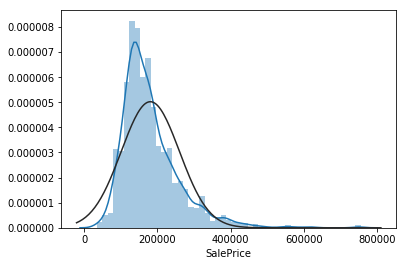

In [42]:
sns.distplot(df['SalePrice'],fit=scipy.stats.norm)
print('kurtosis is ')
print(scipy.stats.kurtosis(df['SalePrice']))

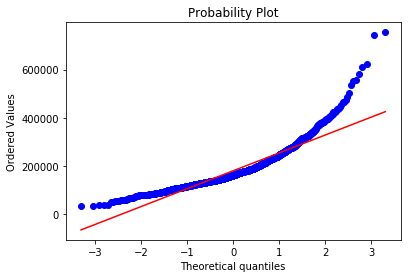

In [43]:
pp = scipy.stats.probplot(df['SalePrice'],plot=plt)

Что можно сказать, основываясь на probplot


В целом, для среднего диапозона цен вполне реально предсказывать, но , как видим, квартиры с очень высокой стоймостью считаются скорее выбросом, чем тем, что мы можем предсказать.
Так что квартиры ценностьюдо 400000 вполне предсказуемы

## 1.2 Анализ некоторых зависимостей (3 балла)

У нас очень много разных признаков. Любопытно построить разные графики. Позаботьтесь о красоте и наглядности графиков, сделайте так, чтобы они были большие и их можно было прочесть. Даже подписи на графиках должны быть читаемые!!

Задания: Постройте графики, отражающие зависимости этих признаков:
- дата постройки дома и его стоимости
- "качество дома и материалов" и его стоимости
- площадь дома и стоимость

Hints: Вспомните про boxplot, jointplot, lmplot...

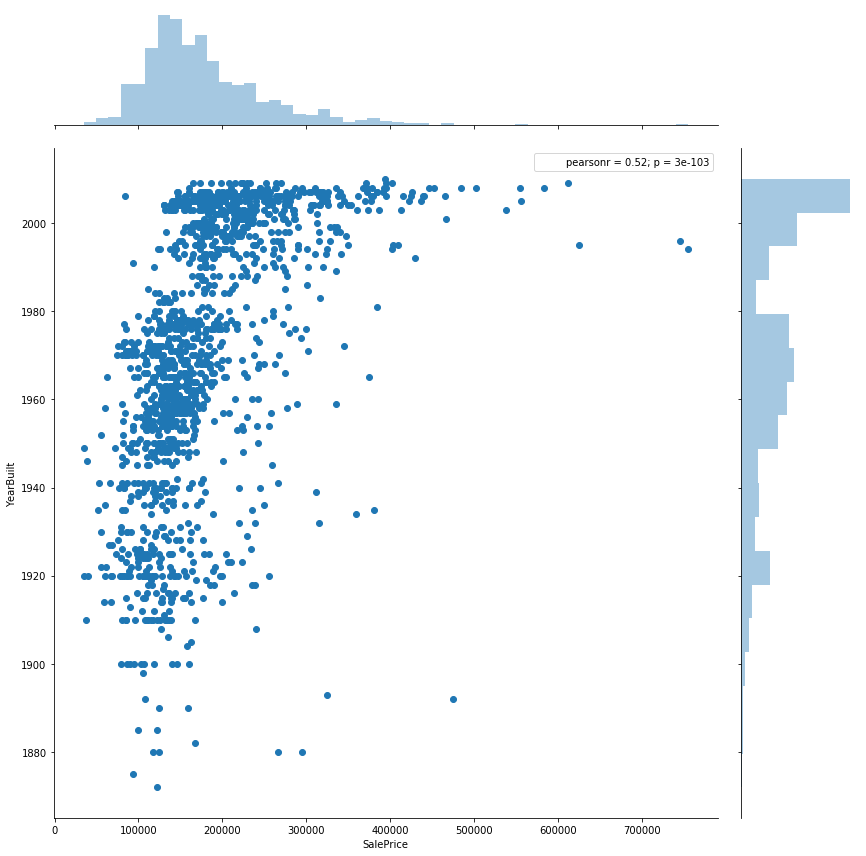

In [44]:
sns.jointplot(data=df,x='SalePrice',y='YearBuilt',size=12)

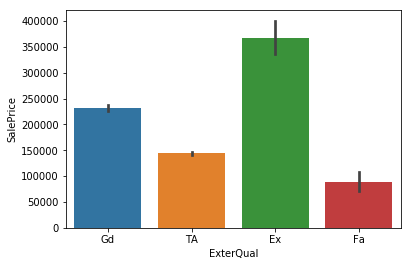

In [45]:
sns.barplot(x='ExterQual', y='SalePrice', data=df)

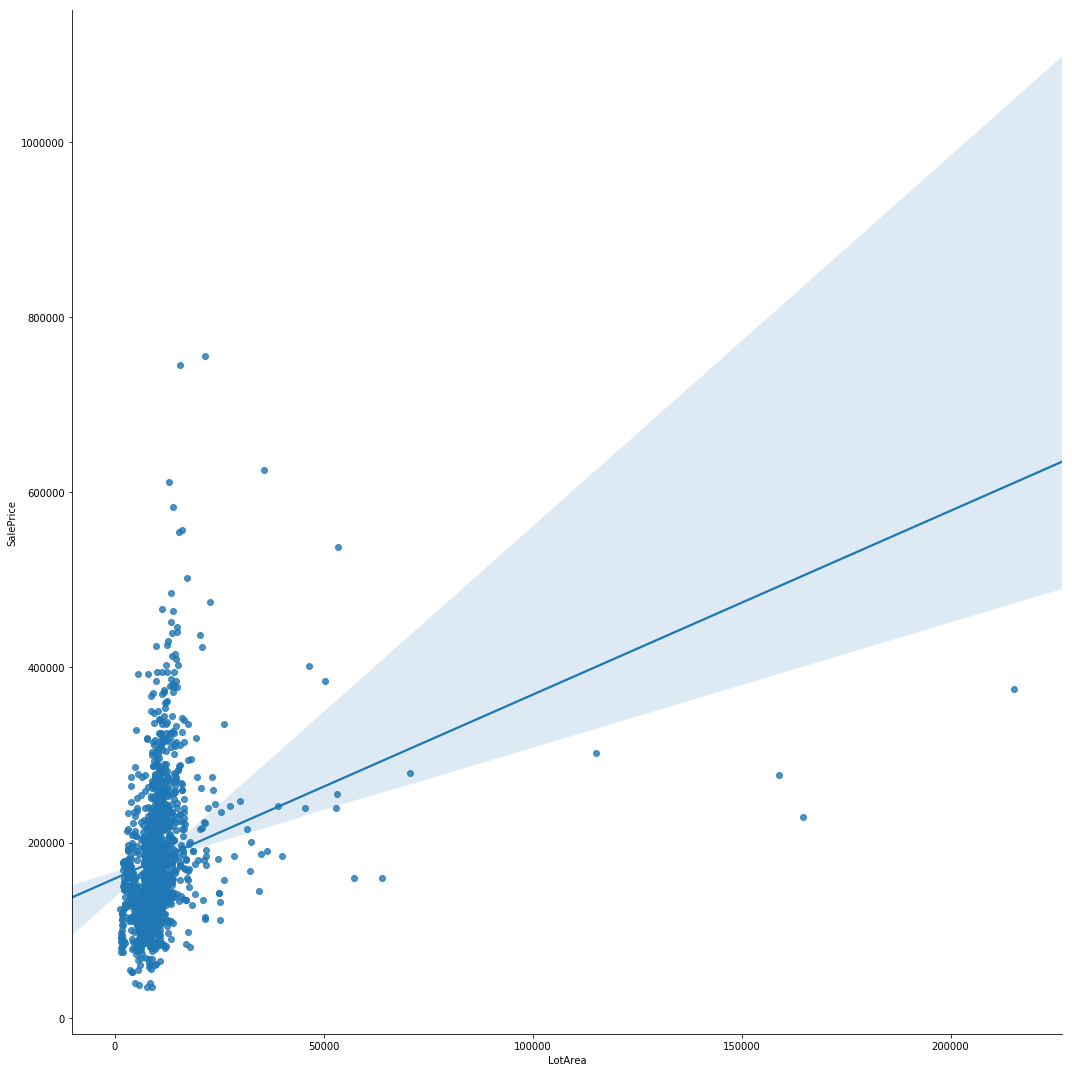

In [46]:
sns.lmplot(data=df,y='SalePrice',x='LotArea',size=15)

## 1.2 Heatmap (3 балла)

Судя по предыдущим графикам, есть некоторые линейные зависимости. Но строить по графику на каждый признак из 80 штук немного долго и не наглядно. Постройте красивый график корреляции всех признаков. Используйте цвета `RdYlGn`, так будет нагляднее. Не забудьте применить маску, чтобы убрать дублирующую половину матрицы.

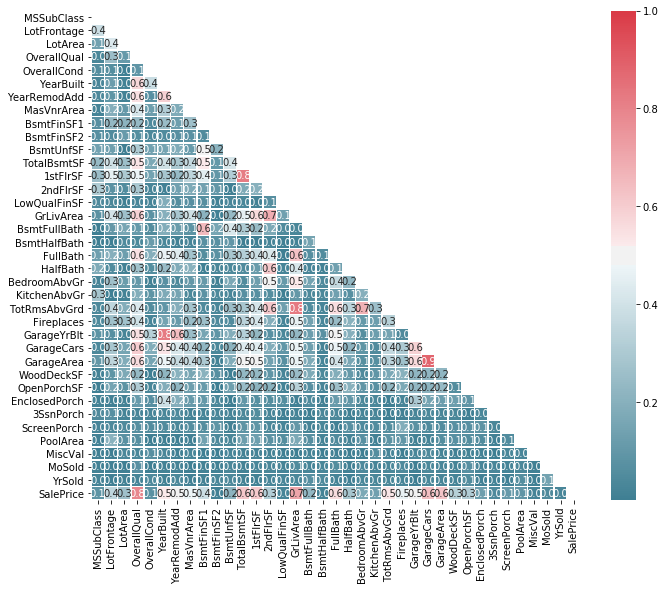

In [47]:
corr = np.abs(df.corr())
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr,cmap=cmap, square=True,linewidths=.5, mask=mask,annot=True, fmt=".1f")

Большая матрица 38x38 ячеек. И мы видим, там есть сильно коррелируемые объекты с нашей целевой переменной. 

- Нарисуйте крупно heatmap этих сильно коррелируемых объектов( больше 0.5 по абсолютному значению) и сделайте так, чтобы в каждой ячейке было значение корреляции. 
- Выведите список этих сильно коррелируемых признаков.

Запомним эти признаки!

In [48]:
m = df.corr()['SalePrice'][np.abs(df.corr()['SalePrice']) >0.5]
dfm = df[m.index]
m

OverallQual     0.790982
YearBuilt       0.522897
YearRemodAdd    0.507101
TotalBsmtSF     0.613581
1stFlrSF        0.605852
GrLivArea       0.708624
FullBath        0.560664
TotRmsAbvGrd    0.533723
GarageCars      0.640409
GarageArea      0.623431
SalePrice       1.000000
Name: SalePrice, dtype: float64

## 1.3 Пропущеные данные (3 балла)

Задание:
 - Посчитайте общее количество пропущенных данных по каждому признаку
 - посчитайте долю пропущенных данных выборки
 - удалите из выборки признаки, доля пропущенных которых больще 10%
 - пропущенные категориальные заполните словом 'unknown' (у них dtype object)
 - пропущенные числовые заполните средним (у них dtype float)

Hinst: https://stackoverflow.com/a/38134049/3205200

In [49]:
df1 = df.isnull()
miss = df1.apply(pd.value_counts)

print('Tottaly miss ', np.count_nonzero(df1) )
print('Tottal miss %' , 100*np.count_nonzero(df1)/(df1.shape[0]*df1.shape[1])  )
miss = miss.T.fillna(0)
miss['%NaN'] = miss[True]/(miss[True]+miss[False])
miss

Tottaly miss  6965
Tottal miss % 5.9631849315068495


,False,True,%NaN
MSSubClass,1460.0,0.0,0.000000
MSZoning,1460.0,0.0,0.000000
LotFrontage,1201.0,259.0,0.177397
LotArea,1460.0,0.0,0.000000
Street,1460.0,0.0,0.000000
Alley,91.0,1369.0,0.937671
LotShape,1460.0,0.0,0.000000
LandContour,1460.0,0.0,0.000000
Utilities,1460.0,0.0,0.000000
LotConfig,1460.0,0.0,0.000000


In [50]:
miss = miss[miss['%NaN'] < 0.1]
miss

,False,True,%NaN
MSSubClass,1460.0,0.0,0.000000
MSZoning,1460.0,0.0,0.000000
LotArea,1460.0,0.0,0.000000
Street,1460.0,0.0,0.000000
LotShape,1460.0,0.0,0.000000
LandContour,1460.0,0.0,0.000000
Utilities,1460.0,0.0,0.000000
LotConfig,1460.0,0.0,0.000000
LandSlope,1460.0,0.0,0.000000
Neighborhood,1460.0,0.0,0.000000


In [51]:
df2 = df.copy()
df2 = df2[miss.T.columns]
df3 = df2.apply(lambda a: a.fillna( 'unknown' ) if a.dtype == object else a.fillna(a.mean() ) )
#неудалось избежать условных конструкций, ибо была мысль использовать умножение на буль, но mean для серий dtype == object
#он всё равно выполняется, если подкинете идейку буду признателен, разделять и снова соединять некрасиво както
df3

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,2,2008,WD,Normal,208500
2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,0,0,0,0,0,5,2007,WD,Normal,181500
3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,9,2008,WD,Normal,223500
4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,0,0,0,0,0,12,2008,WD,Normal,250000
6,50,RL,14115,Pave,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,...,0,320,0,0,700,10,2009,WD,Normal,143000
7,20,RL,10084,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,...,0,0,0,0,0,8,2007,WD,Normal,307000
8,60,RL,10382,Pave,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,...,228,0,0,0,350,11,2009,WD,Normal,200000
9,50,RM,6120,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,...,205,0,0,0,0,4,2008,WD,Abnorml,129900


### 1.4 Категориальные переменные (1 балл)

На сколько вы помните, линейная регрессия не умеет обрабатывать категориальные признаки, так как ей нужны ЧИСЛА. Но не беда, в pandas есть встроенная функция [get_dummies](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html).

Задание:
- сконвертируйте все категориальные признаки(dtype=object) в вектора числовых с помощью get_dummies
- напечатайте сколько у вас теперь признаков
- Положите в переменную X все данные из датасета, кроме целевой переменной. Положите в переменную y только целевую переменную.

In [52]:
dfc = pd.get_dummies(df3, prefix=np.array(df3.columns[df3.dtypes == 'object']))
print('Now we have ' ,dfc.shape[1],' collumns')

Now we have  281  collumns


In [53]:
X = dfc[dfc.columns[dfc.columns != 'SalePrice']]
y = dfc['SalePrice']

## 1.5 Переобучение (3 балла)

Обучим обычную модель без регуляризации [sklearn.linear_model.LinearRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

- Выведите все коэффициенты для каждого признака, отсортировав по возрастанию по модулю значения коэффициента. Используйте print и for, иначе jupyter схлопнет вывод numpy массива. Можете округлить коэффициенты до 2 знаков после запятой.
- Выведите **среднее** ошибки предсказания на 5 фолдах (cv=5) для этой линейной регрессии с помощью функции [sklearn.model_selection.cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html). Укажите `scoring='neg_mean_squared_error'`, чтобы считалась [MSE](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error)

In [60]:
import sklearn.linear_model
lr = sklearn.linear_model.LinearRegression().fit(X,y)

In [62]:
for coef, col in sorted(zip(lr.coef_, dfc.columns), key=lambda x: np.abs(x[0])):
    print("{} \t {}".format(np.round(coef, 4), col))

0.1096 	 MiscVal
0.767 	 LotArea
3.4656 	 OpenPorchSF
4.6865 	 EnclosedPorch
13.3589 	 WoodDeckSF
18.0218 	 GarageArea
18.7586 	 MasVnrArea
-27.0349 	 GarageYrBlt
28.4995 	 ScreenPorch
-31.3989 	 MSSubClass
32.5488 	 3SsnPorch
85.1578 	 PoolArea
97.4219 	 YearRemodAdd
320.6705 	 YearBuilt
-403.9941 	 YrSold
-436.5655 	 MoSold
-616.9709 	 BsmtHalfBath
761.551 	 BsmtFullBath
1098.3248 	 TotRmsAbvGrd
1128.7776 	 HalfBath
2515.4108 	 Fireplaces
-3314.3079 	 BedroomAbvGr
3585.8566 	 FullBath
4264.1607 	 GarageCars
5703.4207 	 OverallCond
6578.7829 	 OverallQual
-12638.0966 	 KitchenAbvGr
-206107251.3477 	 RoofMatl_CompShg
-206135555.766 	 RoofMatl_Membran
-206149461.0015 	 RoofMatl_WdShake
-206196652.6092 	 RoofMatl_Roll
-206202077.5662 	 RoofMatl_ClyTile
-206210610.0236 	 RoofMatl_Tar&Grv
-206213719.4962 	 RoofMatl_Metal
-206868600.4084 	 RoofStyle_Shed
951049585.7299 	 GarageFinish_Fin
951052324.9697 	 GarageFinish_RFn
951052404.6938 	 GarageType_unknown
-1089065095.8489 	 Functional_Sev


In [64]:
error = sklearn.model_selection.cross_val_score(lr,X=X,y=y,cv=5,scoring='neg_mean_squared_error')

In [65]:
np.round(error,3)

array([ -8.25283878e+08,  -1.17623540e+09,  -1.41440984e+09,
        -5.70497624e+08,  -2.18007954e+09])

К счастью в этот раз коэффициенты при признаках не улетели в космос, но всё равно достигли очень больших значений. Например `RoofStyle_Shed` получился в моем случае около `-514961`. А у некоторых признаков коэффициент уже равен 0, хотя не была применена регуляризация.

## 1.6 Ridge и Lasso (4 балла)

- Обучите Lasso и Ridge для разных значений регуляризации alpha
- нарисуйте график значений коэффициентов модели для каждого признака, как мы делали на практике. По оси X будет значение alpha, по Y - значение коэффициента. на графике будет "радуга" из линий разных цветов(линий столько, сколько признаков).
- Нарисуйте гистограмму, в которой по оси Y будет количество коэффициентов, равных 0 (<0.0001) для Loss регресиии, а по оси X - значение коэффициента альфа.

alpha взять от 1 до 500 с каким-нибудь шагом. Но не переборщите, а то долго будете ждать.

In [66]:
from sklearn.linear_model import Ridge , Lasso
alphas = np.arange(1, 500, 5)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1]))
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))

i = 0
for alpha in alphas:
    lasso = Lasso(alpha = alpha, random_state=42)
    lasso.fit(X, y)
    coefs_lasso[i, :] = lasso.coef_
    
    ridge = Ridge(alpha = alpha, random_state=42)
    ridge.fit(X, y)
    coefs_ridge[i, :] = ridge.coef_
    
    i += 1

d:\Users\kkp\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Text(0.5,1,'Ridge')

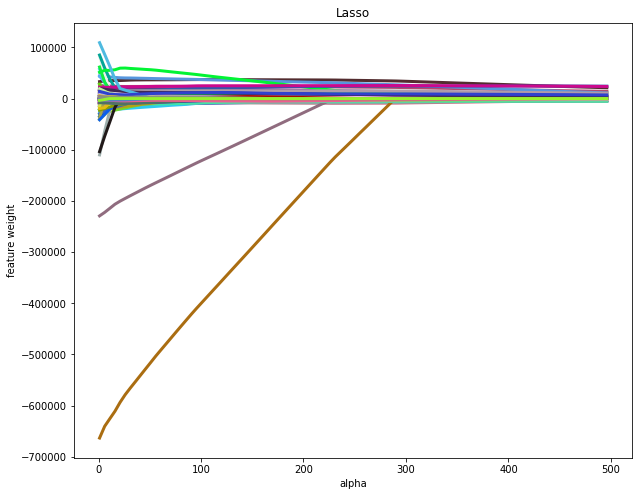

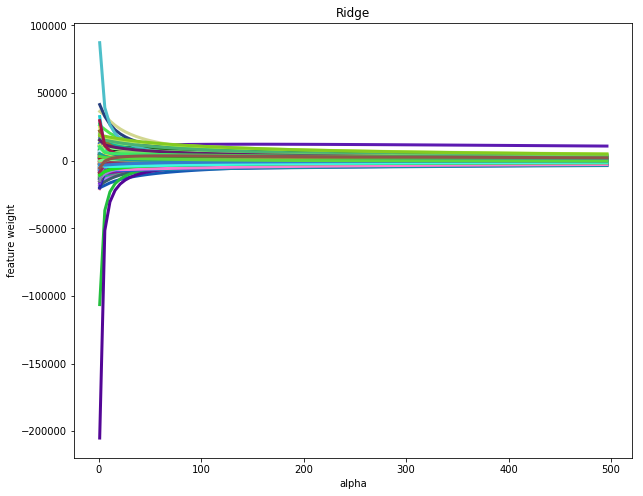

In [67]:
plt.figure(figsize=(10, 8))
for coef, feature in zip(coefs_lasso.T, dfc.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3), linewidth=3)
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(10, 8))
for coef, feature in zip(coefs_ridge.T, dfc.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3), linewidth=3)
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

Нарисуйте гистограмму, в которой по оси Y будет количество коэффициентов, равных 0 (<0.0001) для Loss регресиии, а по оси X - значение коэффициента альфа.

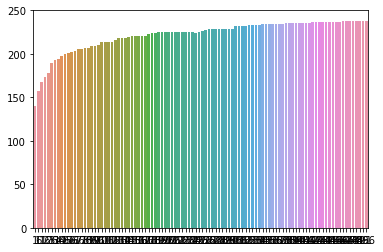

In [68]:
emp = np.zeros(alphas.shape)
for alpha in range(alphas.shape[0]):
    emp[alpha] = coefs_lasso[alpha][coefs_lasso[alpha]<0.0001].shape[0]
    
sns.barplot(alphas,emp)

## 1.7 Поиск оптимального alpha (6 баллов)

- С помощью метода LassoCV найдите оптимальное значение alpha и напечатайте его, используя разбиение на 5 фолда в кроссвалидации (`cv=5`).
- Нарисуйте график зависимости MSE от alpha (`mse_path_`).
- Нарисуйте длинную гистограмму магнитуда признаков, как в классе, на которой будет показано значение коэффициента для каждого признака. Графк должен быть остортирован по величине коэффициентов. Признаки с нулевыми коэффициентами должны быть удалены.
- Сколько в итоге ненулевых признаков осталось?
- Выведите **среднее** ошибки предсказания на 5 фолдах (cv=5) для этой линейной регрессии с помощью функции [sklearn.model_selection.cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html). Укажите `scoring='neg_mean_squared_error'`, чтобы считалась [MSE](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error). Качество должно быть лучше, чем у простой линейной регрессии.

In [69]:
import sklearn.linear_model
alphas = np.arange(1, 500, 5)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1]))

lassocv = sklearn.linear_model.LassoCV(cv=5,alphas=alphas ,random_state=42)
lassocv.fit(X, y)

d:\Users\kkp\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


LassoCV(alphas=array([  1,   6, ..., 491, 496]), copy_X=True, cv=5, eps=0.001,
    fit_intercept=True, max_iter=1000, n_alphas=100, n_jobs=1,
    normalize=False, positive=False, precompute='auto', random_state=42,
    selection='cyclic', tol=0.0001, verbose=False)

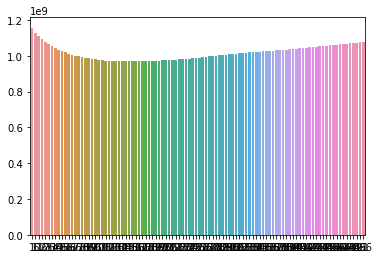

In [70]:
sns.barplot(lassocv.alphas_,lassocv.mse_path_.mean(axis=1))

Оптимальный альфа

In [71]:
lassocv.alpha_

146

Нарисуйте длинную гистограмму магнитуда признаков, как в классе, на которой будет показано значение коэффициента для каждого признака. Графк должен быть остортирован по величине коэффициентов. Признаки с нулевыми коэффициентами должны быть удалены.

## 1.8 Предсказание на отложенной выборке (3 балла)

- Используя [sklearn.model_selection.train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) разбейте датасет на 2 части - тренировочную и тестовую в соотношении 0.33. Не забудьте перемешать!
- Напечатайте размерность X_train и X_test

Теперь, возьмите вашу самую мощную модель(не тренированную!). Запустите её тренировку по тренировочной выборке X_train, y_train с помощью функции `fit`. Постройте предсказания с помощью функции `predict`.

Визуализируйте scatter plot предсказанных значений и настоящих (`y_test`). У вас должен получиться график, точки которого расположены приблизительно вдоль некоторой прямой с разбросом. Идеальный предсказатель будет выглядить как набор точек вдоль прямой без разброса.

## 1.9 Ограниченная версия ( 4 балла)

Помните в самом начале мы оставили очень мало признаков по данным из heatmap. Настало время проверить как он себя покажет! К счастью они все сразу числовые, а не категориальные. Переиспользуйте тот дадасет, где вы уже поборолись с пропусками.
Снова выделите отдельно X и y и запустите кроссвалидацию c 5 фолдами по Lasso с `alpha=1`.

Можете посмотреть еще много разных примеров обработки этого датасета тут: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/kernels

А суть всего этого такова, что в итоге надо кучу времени потратить на подготовку признаков. Смотреть на кучу графиков а потом стакать модели.